In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

#X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
#Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

X_motion = X_footsteps_accelerations_absolute
Y_motion = Y_footsteps_accelerations_absolute

print(X_motion.shape)
print(Y_motion.shape)

(5387, 24)
(5387, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, -2] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging[10]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.21840438,  0.13003148, -0.37701634,  0.25918305,
       -0.13256112, -0.3703649 , -0.23936759,  0.12442393, -0.38166779,
       -0.27998325, -0.12794775, -0.37933218,  0.14566456, -0.04575961,
        0.05389997,  0.06813524,  1.        ,  0.        ])

In [9]:
X_motion_FL_swinging[10, 18:22]

array([ 0.14566456, -0.04575961,  0.05389997,  0.06813524])

In [10]:
Y_motion_FL_swinging.shape

(2698, 4)

In [11]:
X_motion_FL_swinging[0:10, 0]

array([0.1, 0.1, 0. , 0. , 0.1, 0.1, 0.1, 0. , 0.1, 0. ])

### Linear Regression

In [25]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9902229780241864
RMSE:  0.0159834818116676
The lowest error is:  2.8676459770116125e-05
The highest error is:  0.055923310490808065
The avg. error is:  0.012333239323706275


In [26]:
model_fl_relative_support_x.coef_

array([[ 1.40279092e-02, -4.99600361e-16, -9.71445147e-16,
         1.08621104e-01,  2.77555756e-16, -1.94289029e-16,
         3.97684829e-01,  3.52009734e-01, -1.12523521e-01,
        -7.14378290e-04, -6.47822537e-01, -8.93822283e-01,
        -8.25165590e-01,  5.76822396e-01,  2.17618000e-01,
         1.09877543e+00, -3.45350203e-01,  6.29666151e-01]])

In [27]:
model_fl_relative_support_x.intercept_

array([0.46885229])

Text(0, 0.5, 'Predictions')

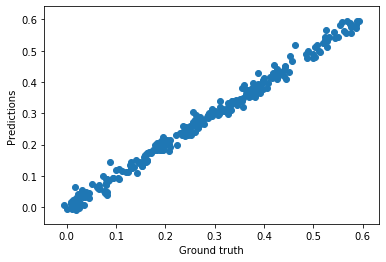

In [28]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [29]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict FL foot -> y

In [32]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # Previous motion command
               X_motion_FL_swinging[:, 3:6], # Current motion command
               X_motion_FL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_FL_swinging[:, 6:8], # FL (x,y) position
               X_motion_FL_swinging[:, 9:11], # FR (x,y) position
               X_motion_FL_swinging[:, 12:14], # RL (x,y) position
               X_motion_FL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.7677409030158812
RMSE:  0.005453113238036263
The lowest error is:  4.948576166972918e-05
The highest error is:  0.015518122925881686
The avg. error is:  0.004384046747482615


In [33]:
model_fl_relative_support_y.coef_

array([[-5.89003645e-03, -4.16333634e-17,  3.40005801e-16,
        -5.01935848e-03, -1.24900090e-16, -1.56125113e-16,
         8.36258980e-02,  4.36105605e-02, -1.67269514e-02,
        -7.71144734e-03,  1.82965128e-01, -1.36326557e+00,
        -1.93187865e-02,  4.66495023e-01, -2.96620343e-01,
         4.93508728e-01, -1.24692982e-01, -3.12202613e-01]])

In [34]:
model_fl_relative_support_y.intercept_

array([-0.01502302])

Text(0, 0.5, 'Predictions')

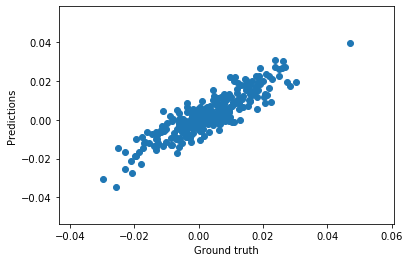

In [35]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [86]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')